In [1]:
import numpy as np
import math as math
from importlib import reload  # Python 3.4+

import src.nav_alg
src.nav_alg = reload(src.nav_alg)
from src.nav_alg import nav_alg
from src.csv_parser import get_data_from_csv
from src.white_noize_gen import gen_white_noize

import logging
logging.basicConfig(
    format='%(module)s:%(levelname)s:%(message)s',
    filename='logs/Run.log',
    filemode="w",
    encoding='utf-8',
    level=logging.WARNING)
logging.getLogger('src.nav_alg').setLevel(logging.INFO)

In [2]:
"""
    Config section
"""
# e.g Moscow
lat = 0#55.75
lon = 0#37.61

# file with real sensors data
data_file = "csv_data/Sensors_and_orientation.csv"
sample_time = 1800 # seconds
data_frequency = 100 # Hz
do_gen_white_noize = False
save_plots = False # plots would be saved to images folder
plots_size = (297,210) # plots height,width in mm
# additional plots such as wx,wy,wz,ax,ay,az in both body and enu would be shown
show_additional_plots = False
# Should we use real data based alignment, otherwize ideal alignment would be used
use_alignment=False
# heading from -150 to 150
alignment_heading = 0
# time for alignment in seconds
alignment_time = 120
# sensor errors
acc_offset = 0.0001 # [m/s/s] e.g 1 [mg]
gyr_drift = math.radians(10)/3600 # [deg/hour] e.g. 10 [deg/hour]

"""
    Config section end
"""

'\n    Config section end\n'

In [3]:
ideal_system = nav_alg(obj_name="Идеальная система")

acc_offset_analysis = nav_alg(obj_name="смещение 0 акселерометров")
acc_offset_analysis.set_a_body(
    acc_offset,
    acc_offset,
    acc_offset
)
acc_offset_analysis.set_coordinates(lat, lon)

gyro_drift_analysis= nav_alg(obj_name="дрейф гироскопов")
gyro_drift_analysis.set_w_body(
    gyr_drift,
    gyr_drift,
    gyr_drift
)
gyro_drift_analysis.set_coordinates(lat, lon)

In [4]:
SENSOR_DATA = get_data_from_csv("Gyr_X","Gyr_Y","Gyr_Z","Acc_X","Acc_Y","Acc_Z", file_name=data_file)

In [5]:
gyro_random_error_analysis = nav_alg(analysis="dynamic_gyro", time=sample_time, frequency=data_frequency, obj_name="случайная ошибка гироскопов")
gyro_random_error_analysis.set_coordinates(lat, lon)

SENSOR_DATA_GYR = SENSOR_DATA
if do_gen_white_noize:
    SENSOR_DATA_GYR.update({ "Gyr_X": gen_white_noize(np.std(SENSOR_DATA_GYR["Gyr_X"]), sample_time, data_frequency)})
    SENSOR_DATA_GYR.update({ "Gyr_Y": gen_white_noize(np.std(SENSOR_DATA_GYR["Gyr_Y"]), sample_time, data_frequency)})
    SENSOR_DATA_GYR.update({ "Gyr_Z": gen_white_noize(np.std(SENSOR_DATA_GYR["Gyr_Z"]), sample_time, data_frequency)})
else:
    SENSOR_DATA_GYR.update({ "Gyr_X":(SENSOR_DATA_GYR["Gyr_X"]-np.mean(SENSOR_DATA_GYR["Gyr_X"])) })
    SENSOR_DATA_GYR.update({ "Gyr_Y":(SENSOR_DATA_GYR["Gyr_Y"]-np.mean(SENSOR_DATA_GYR["Gyr_Y"])) })
    SENSOR_DATA_GYR.update({ "Gyr_Z":(SENSOR_DATA_GYR["Gyr_Z"]-np.mean(SENSOR_DATA_GYR["Gyr_Z"])) })

gyro_random_error_analysis.sensor_data = SENSOR_DATA_GYR

In [6]:
acc_random_error_analysis = nav_alg(analysis="dynamic_acc", time=sample_time, frequency=data_frequency, obj_name="случайная ошибка акселерометров, выставка не проводится")
acc_random_error_analysis.set_coordinates(lat, lon)

SENSOR_DATA_ACC = SENSOR_DATA
if do_gen_white_noize:
    SENSOR_DATA_ACC.update({ "Acc_X": gen_white_noize(np.std(SENSOR_DATA_ACC["Acc_X"]), sample_time, data_frequency)})
    SENSOR_DATA_ACC.update({ "Acc_Y": gen_white_noize(np.std(SENSOR_DATA_ACC["Acc_Y"]), sample_time, data_frequency)})
    SENSOR_DATA_ACC.update({ "Acc_Z": gen_white_noize(np.std(SENSOR_DATA_ACC["Acc_Z"]), sample_time, data_frequency)})
else:
    SENSOR_DATA_ACC.update({ "Acc_X":(SENSOR_DATA_ACC["Acc_X"]-np.mean(SENSOR_DATA_ACC["Acc_X"])) })
    SENSOR_DATA_ACC.update({ "Acc_Y":(SENSOR_DATA_ACC["Acc_Y"]-np.mean(SENSOR_DATA_ACC["Acc_Y"])) })
    SENSOR_DATA_ACC.update({ "Acc_Z":(SENSOR_DATA_ACC["Acc_Z"]-np.mean(SENSOR_DATA_ACC["Acc_Z"])) })

acc_random_error_analysis.sensor_data = SENSOR_DATA_ACC

In [7]:
acc_random_error_analysis_w_a = None
if use_alignment:
    acc_random_error_analysis_w_a = nav_alg(analysis="dynamic_acc", time=sample_time, frequency=data_frequency, obj_name="случайная ошибка акселерометров, выставка по ЗК")
    acc_random_error_analysis_w_a.set_coordinates(lat, lon)

    SENSOR_DATA_ACC_W_A = SENSOR_DATA
    if do_gen_white_noize:
        SENSOR_DATA_ACC_W_A.update({ "Acc_X": gen_white_noize(np.std(SENSOR_DATA_ACC_W_A["Acc_X"]), sample_time, data_frequency)})
        SENSOR_DATA_ACC_W_A.update({ "Acc_Y": gen_white_noize(np.std(SENSOR_DATA_ACC_W_A["Acc_Y"]), sample_time, data_frequency)})
        SENSOR_DATA_ACC_W_A.update({ "Acc_Z": gen_white_noize(np.std(SENSOR_DATA_ACC_W_A["Acc_Z"]), sample_time, data_frequency)})
    else:
        SENSOR_DATA_ACC_W_A.update({ "Acc_X":(SENSOR_DATA_ACC_W_A["Acc_X"]-np.mean(SENSOR_DATA_ACC_W_A["Acc_X"])) })
        SENSOR_DATA_ACC_W_A.update({ "Acc_Y":(SENSOR_DATA_ACC_W_A["Acc_Y"]-np.mean(SENSOR_DATA_ACC_W_A["Acc_Y"])) })
        SENSOR_DATA_ACC_W_A.update({ "Acc_Z":(SENSOR_DATA_ACC_W_A["Acc_Z"]-np.mean(SENSOR_DATA_ACC_W_A["Acc_Z"])) })

    acc_random_error_analysis_w_a.sensor_data = SENSOR_DATA_ACC_W_A
    acc_random_error_analysis_w_a.alignment(use_alignment,alignment_heading, alignment_time)

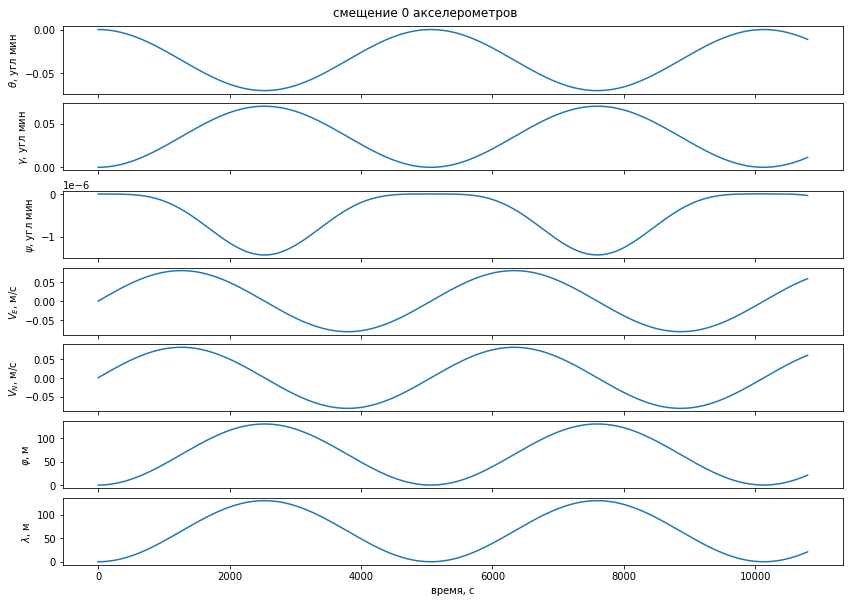

In [8]:
import threading
    
def create_threads_and_run(*objects):
    threads = []
    for object in objects:
        if object != None:
            threads.append(threading.Thread(target=object.analysis))
    
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()

    for object in objects:
        if object != None:
            object.plots(size=plots_size, save=save_plots, additional_plots=show_additional_plots)


create_threads_and_run(
    acc_offset_analysis,
    gyro_drift_analysis,
    gyro_random_error_analysis,
    acc_random_error_analysis,
    acc_random_error_analysis_w_a,
    ideal_system
    )

In [9]:
#ideal_system.plots(save=False, title="ideal")
#acc_offset_analysis.plots(save=False, title="acc_offset")
#gyro_drift_analysis.plots(save=False, title="gyro drift")
#gyro_random_error_analysis.plots(save=False, title="gyr rnd")
#acc_random_error_analysis.plots(save=False, title="acc rnd")